In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('whitegrid')

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.sql.types import NumericType

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Video Games Sales Analysis") \
    .getOrCreate()

In [ ]:
df = spark.read.csv('../data/cleaned_data.csv', header=True, inferSchema=True)

In [5]:
pandas_df = df.toPandas()

In [6]:
df.show(5, truncate=False)

+--------------------------------------+----+--------+----+------------+---------------------------+--------+--------+--------+-----------+------------+-------------------+------------------+--------------------+-------------------+------------------+------------+
|Name                                  |Rank|Platform|Year|Genre       |Publisher                  |NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|NA_Sales_log       |EU_Sales_log      |JP_Sales_log        |Other_Sales_log    |Global_Sales_log  |Is_Japan_Hit|
+--------------------------------------+----+--------+----+------------+---------------------------+--------+--------+--------+-----------+------------+-------------------+------------------+--------------------+-------------------+------------------+------------+
|FIFA Soccer 11                        |200 |PS3     |2010|Sports      |Electronic Arts            |0.6     |3.29    |0.06    |1.13       |5.08        |0.4700036292457356 |1.4562867329399256|0.058268908123

In [7]:
num_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

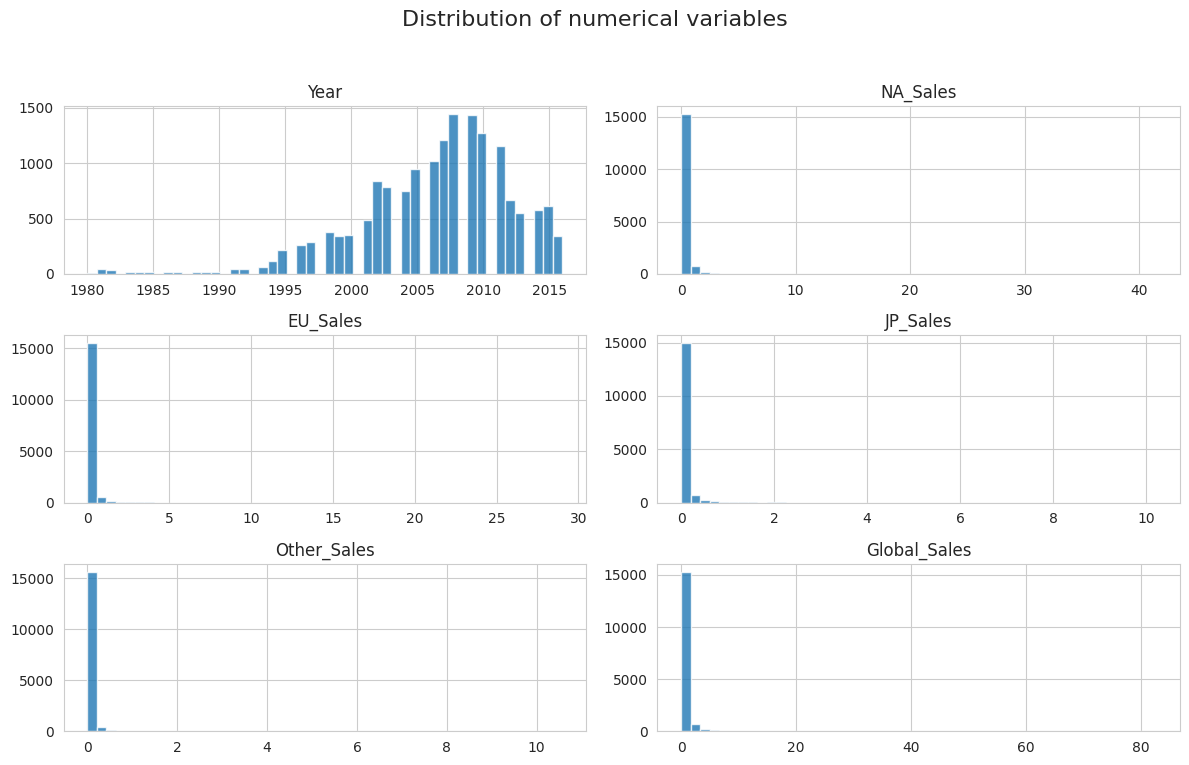

In [41]:
pandas_df[num_cols[1:7]].hist(bins=50, alpha=0.8, figsize=(12, 8))
plt.suptitle("Distribution of numerical variables", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

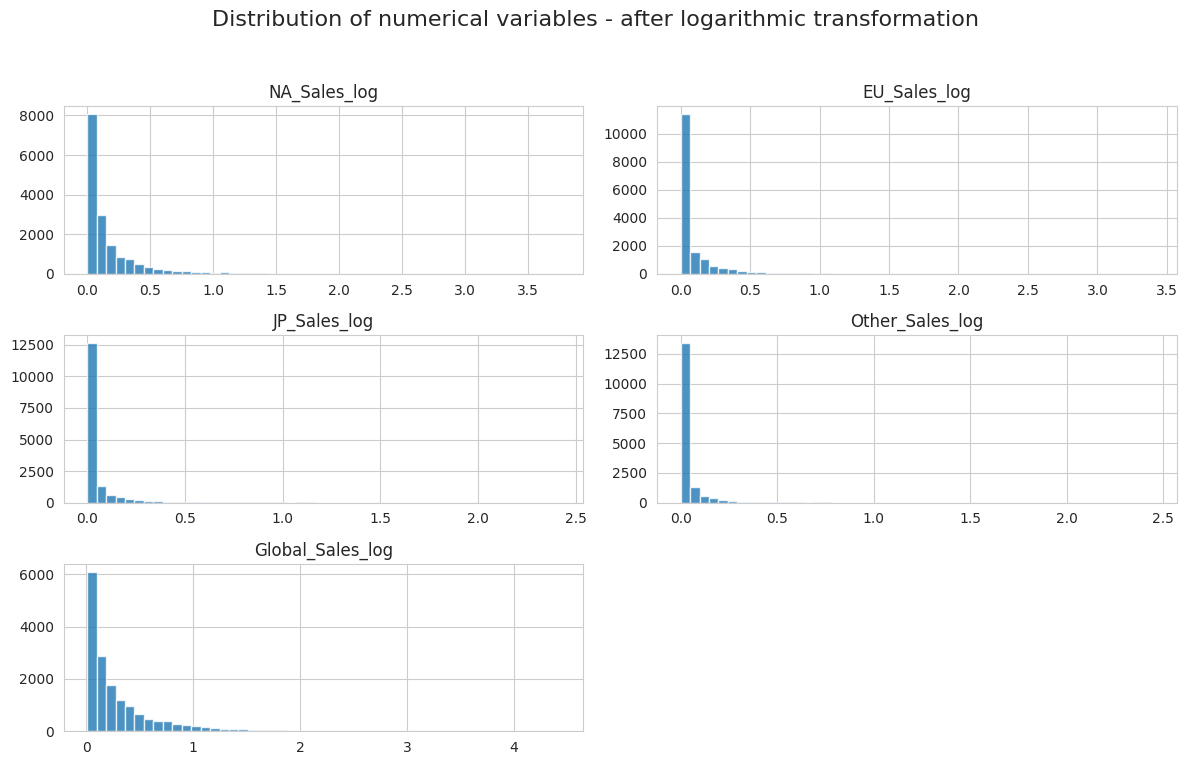

In [40]:
pandas_df[num_cols[7:12]].hist(bins=50, alpha=0.8, figsize=(12, 8))
plt.suptitle("Distribution of numerical variables - after logarithmic transformation", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Sales & Performance Analysis

### Which game has the highest global sales overall?

In [10]:
print('Top 5 highest global sales:')
df.orderBy(col("Global_Sales").desc()).select("Name", "Platform", "Global_Sales").show(5, truncate=False)

Top 5 highest global sales:
+------------------------+--------+------------+
|Name                    |Platform|Global_Sales|
+------------------------+--------+------------+
|Wii Sports              |Wii     |82.74       |
|Super Mario Bros.       |NES     |40.24       |
|Mario Kart Wii          |Wii     |35.82       |
|Wii Sports Resort       |Wii     |33.0        |
|Pokemon Red/Pokemon Blue|GB      |31.37       |
+------------------------+--------+------------+
only showing top 5 rows



### What are the top 10 best-selling games in each region?

In [11]:
regions = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
for region in regions:
    print(f"Top 10 in {region}:")
    df.orderBy(col(region).desc()).select("Name", "Platform", region).show(10, truncate=False)

Top 10 in NA_Sales:
+-------------------------+--------+--------+
|Name                     |Platform|NA_Sales|
+-------------------------+--------+--------+
|Wii Sports               |Wii     |41.49   |
|Super Mario Bros.        |NES     |29.08   |
|Duck Hunt                |NES     |26.93   |
|Tetris                   |GB      |23.2    |
|Mario Kart Wii           |Wii     |15.85   |
|Wii Sports Resort        |Wii     |15.75   |
|Kinect Adventures!       |X360    |14.97   |
|New Super Mario Bros. Wii|Wii     |14.59   |
|Wii Play                 |Wii     |14.03   |
|Super Mario World        |SNES    |12.78   |
+-------------------------+--------+--------+
only showing top 10 rows

Top 10 in EU_Sales:
+--------------------------------------------+--------+--------+
|Name                                        |Platform|EU_Sales|
+--------------------------------------------+--------+--------+
|Wii Sports                                  |Wii     |29.02   |
|Mario Kart Wii               

### Top global sales by genre

In [12]:
genre_sales = df.groupBy("Genre") \
    .agg(sum("Global_Sales").alias("Total_Global_Sales")) \
    .orderBy(col("Total_Global_Sales").desc())

genre_sales_pd = genre_sales.toPandas().sort_values("Total_Global_Sales", ascending=False)

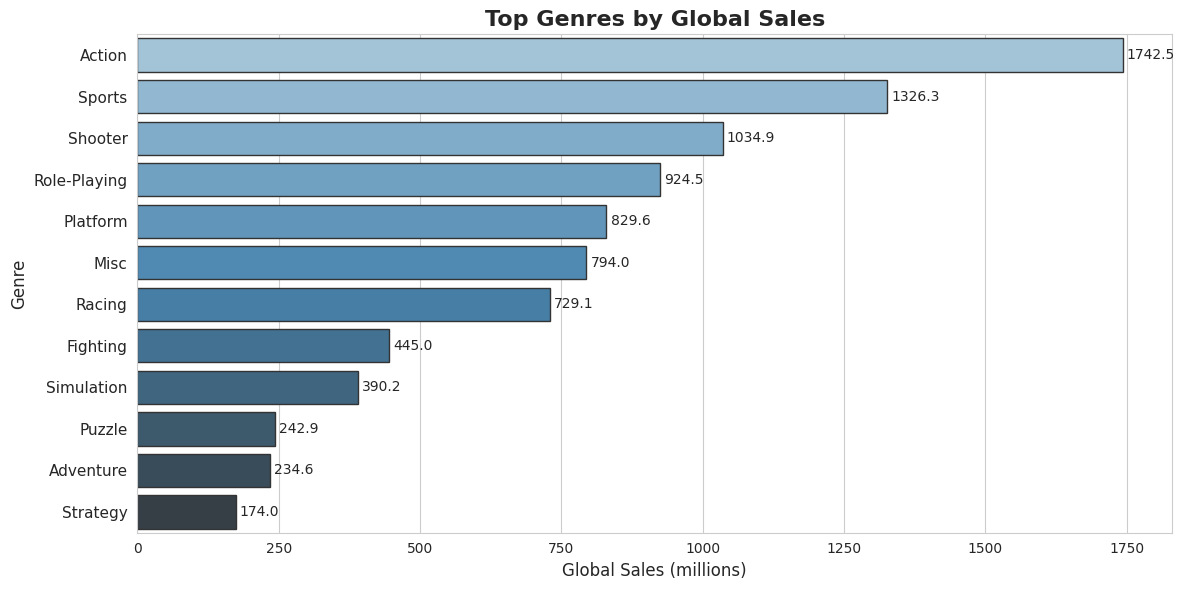

In [13]:
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=genre_sales_pd,
    x="Total_Global_Sales",
    y="Genre",
    hue='Genre',
    palette="Blues_d",
    edgecolor=".2"
)

plt.title("Top Genres by Global Sales", fontsize=16, fontweight='bold')
plt.xlabel("Global Sales (millions)", fontsize=12)
plt.ylabel("Genre", fontsize=12)

for container in barplot.containers:
    barplot.bar_label(container, fmt="%.1f", label_type="edge", padding=3)

plt.xticks(fontsize=10)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

### Most profitable platforms with number of games and average sales per game

In [14]:
platform_summary = df.groupBy("Platform").agg(
    count("*").alias("Num_Games"),
    round(sum("Global_Sales"), 2).alias("Total_Global_Sales"),
    round(avg("Global_Sales"), 2).alias("Avg_Sales_Per_Game"),
    round(sum("JP_Sales"), 2).alias("Total_JP_Sales")
).orderBy(col("Total_Global_Sales").desc())

platform_summary.show()

+--------+---------+------------------+------------------+--------------+
|Platform|Num_Games|Total_Global_Sales|Avg_Sales_Per_Game|Total_JP_Sales|
+--------+---------+------------------+------------------+--------------+
|     PS2|     2140|           1247.05|              0.58|        137.74|
|    X360|     1253|            975.11|              0.78|         12.33|
|     PS3|     1318|            953.32|              0.72|         79.32|
|     Wii|     1305|            922.34|              0.71|         69.05|
|      DS|     2138|            820.27|              0.38|        175.02|
|      PS|     1189|            727.39|              0.61|        139.78|
|     GBA|      788|            306.46|              0.39|         46.56|
|     PSP|     1207|             295.8|              0.25|         76.39|
|     PS4|      335|            278.07|              0.83|         14.27|
|      PC|      951|            257.81|              0.27|          0.17|
|      XB|      817|            257.19

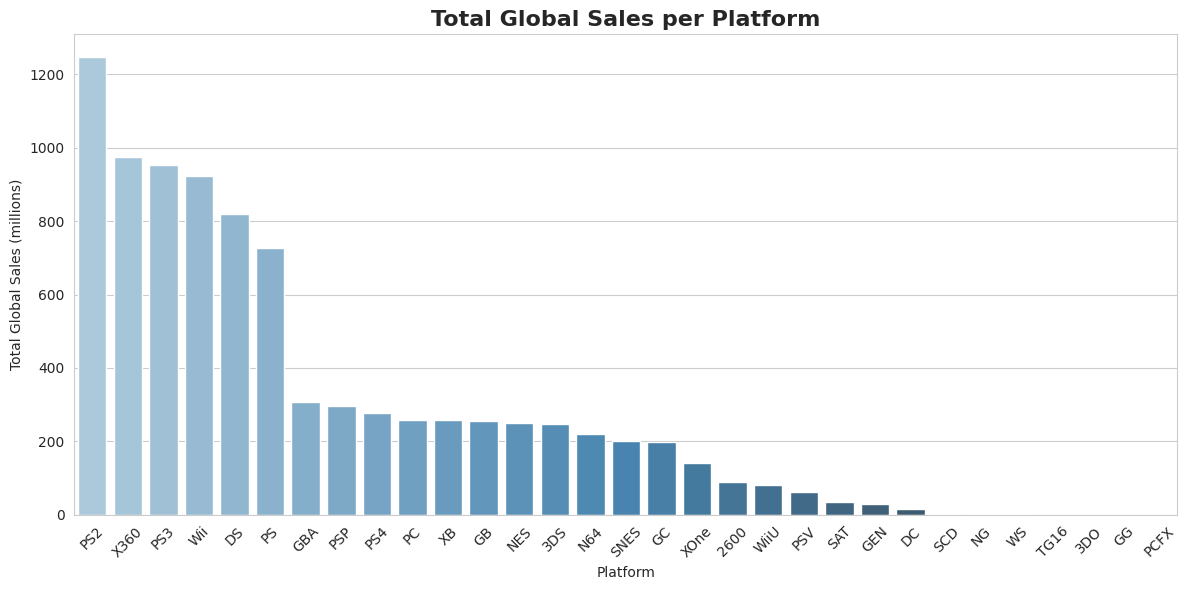

In [15]:
platform_pd = platform_summary.toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=platform_pd, x="Platform", y="Total_Global_Sales", hue='Platform', palette="Blues_d")
plt.title("Total Global Sales per Platform",fontsize=16, fontweight='bold')
plt.ylabel("Total Global Sales (millions)")
plt.xlabel("Platform")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

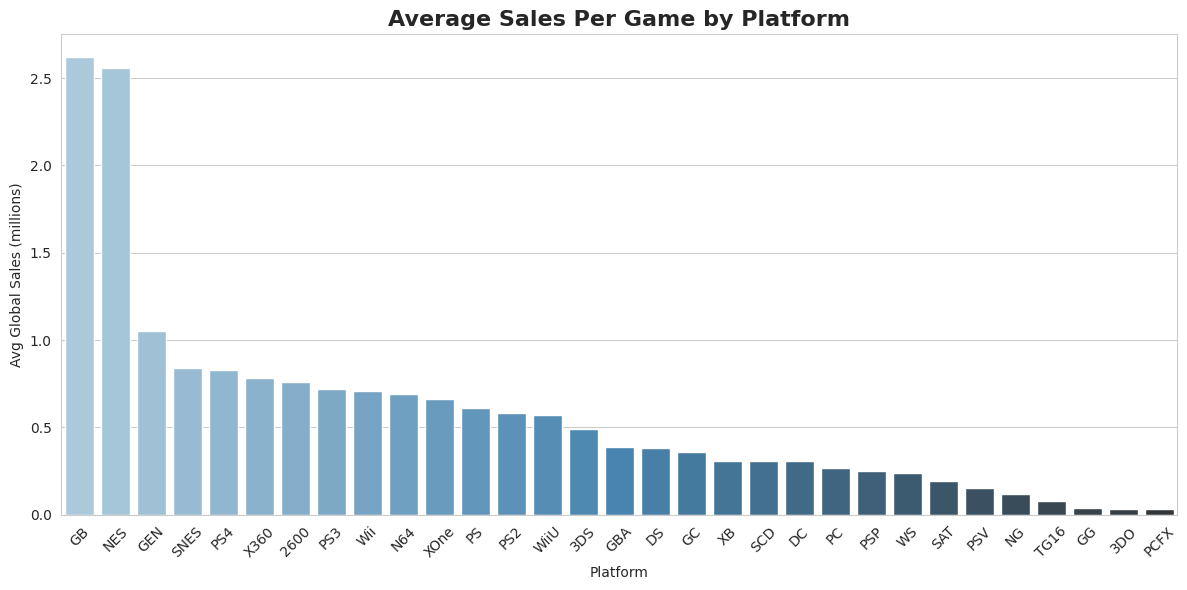

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(data=platform_pd.sort_values(by=["Avg_Sales_Per_Game"], ascending=False), x="Platform", y="Avg_Sales_Per_Game", hue='Platform', palette="Blues_d")
plt.title("Average Sales Per Game by Platform",fontsize=16, fontweight='bold')
plt.ylabel("Avg Global Sales (millions)")
plt.xlabel("Platform")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

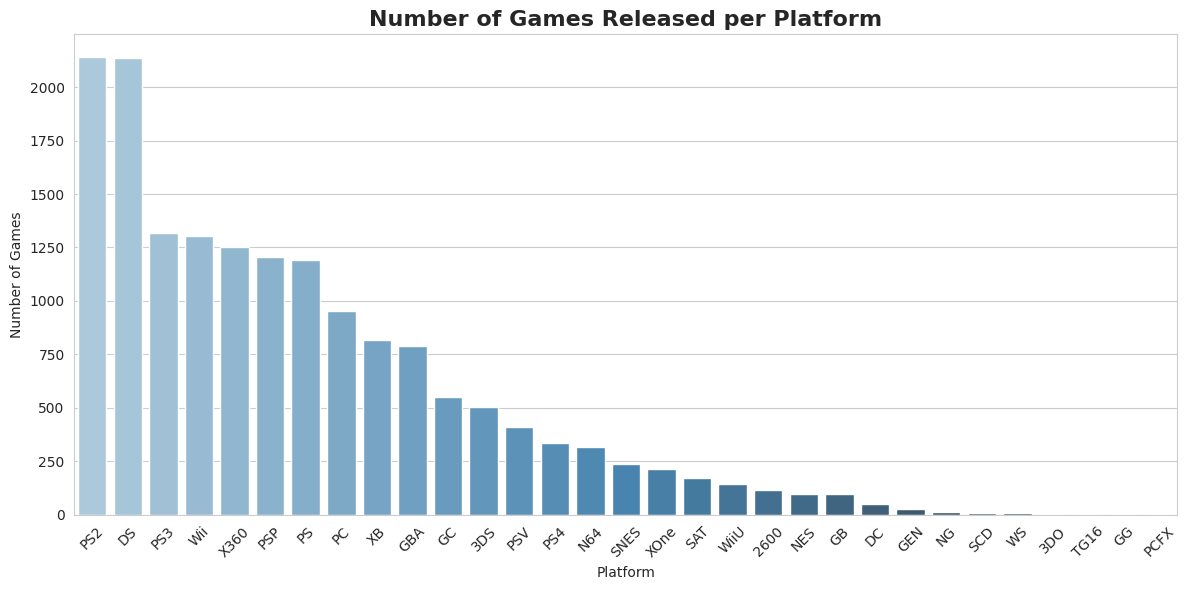

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(data=platform_pd.sort_values(by=['Num_Games'], ascending=False), x="Platform", y="Num_Games", hue='Platform', palette="Blues_d")
plt.title("Number of Games Released per Platform", fontsize=16, fontweight='bold')
plt.ylabel("Number of Games")
plt.xlabel("Platform")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Time & Trend Analysis

###  Global sales over time

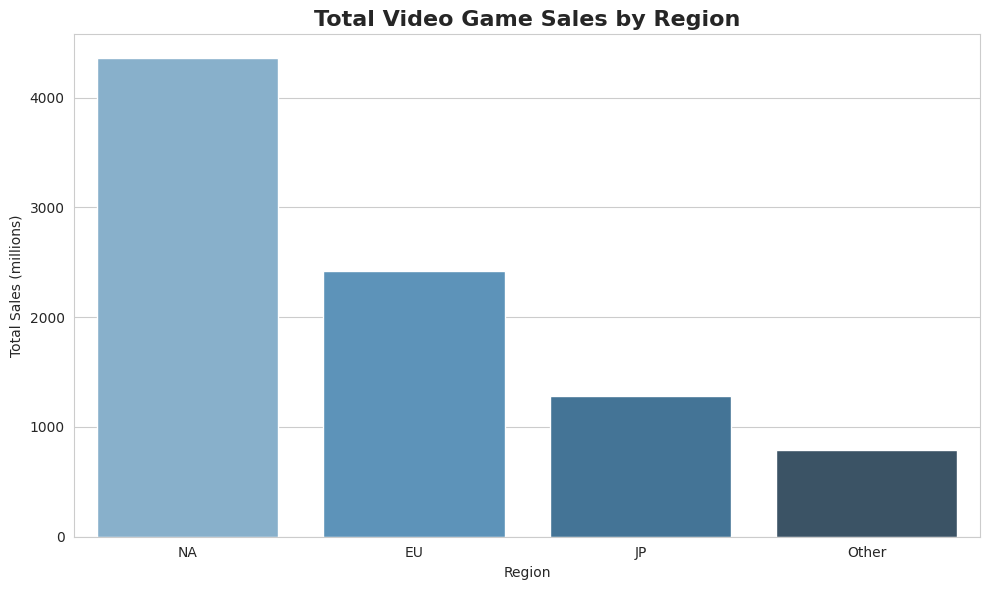

In [18]:
region_sales = df.select("NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales") \
    .agg(
        sum("NA_Sales").alias("NA"),
        sum("EU_Sales").alias("EU"),
        sum("JP_Sales").alias("JP"),
        sum("Other_Sales").alias("Other")
    )

region_sales_pd = region_sales.toPandas().T.reset_index()
region_sales_pd.columns = ["Region", "Total_Sales"]
region_sales_pd = region_sales_pd.sort_values("Total_Sales", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=region_sales_pd, x="Region", y="Total_Sales", hue= "Region", palette="Blues_d")

plt.title("Total Video Game Sales by Region", fontsize=16, fontweight='bold')
plt.xlabel("Region")
plt.ylabel("Total Sales (millions)")
plt.tight_layout()
plt.show()

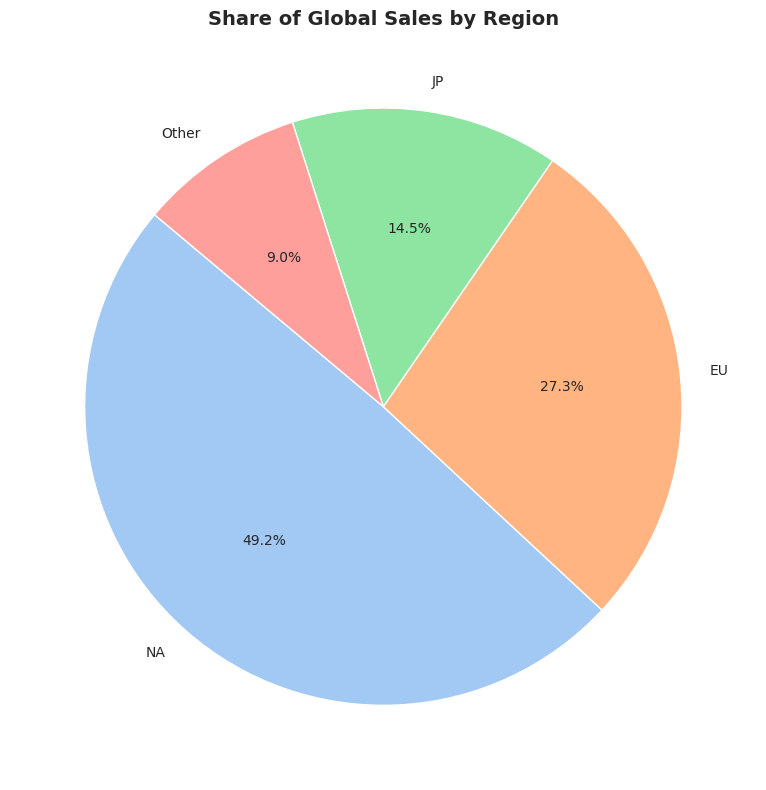

In [19]:
plt.figure(figsize=(8, 8))
plt.pie(region_sales_pd["Total_Sales"], labels=region_sales_pd["Region"],
        autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Share of Global Sales by Region", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [20]:
sales_by_year = df.groupBy("Year") \
    .agg(sum("Global_Sales").alias("Total_Global_Sales")) \
    .orderBy("Year")

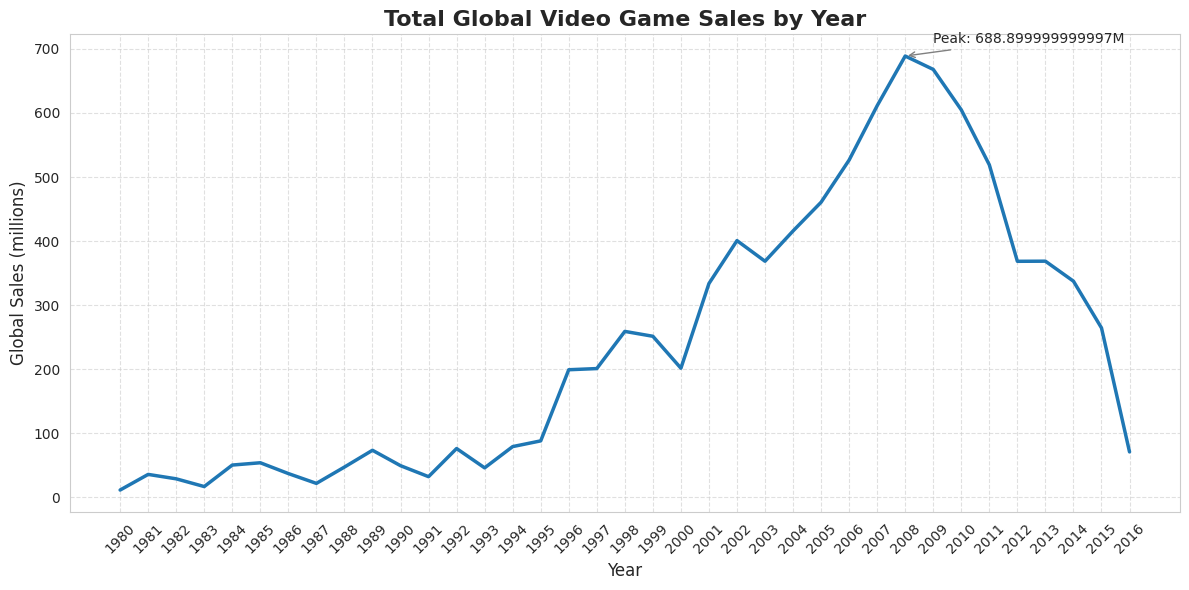

In [21]:
sales_by_year_pd = sales_by_year.toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=sales_by_year_pd,
    x="Year",
    y="Total_Global_Sales",
    linewidth=2.5
)

plt.title("Total Global Video Game Sales by Year", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Global Sales (millions)", fontsize=12)

plt.xticks(sales_by_year_pd["Year"].unique(), rotation=45)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

peak = sales_by_year_pd.loc[sales_by_year_pd["Total_Global_Sales"].idxmax()]
plt.annotate(f"Peak: {peak['Total_Global_Sales']}M",
             xy=(peak["Year"], peak["Total_Global_Sales"]),
             xytext=(peak["Year"] + 1, peak["Total_Global_Sales"] + 20),
             arrowprops=dict(arrowstyle="->", color='gray'),
             fontsize=10)

plt.tight_layout()
plt.show()

In [22]:
regional_sales_by_year = df.groupBy("Year").agg(
    sum("NA_Sales").alias("NA_Sales"),
    sum("EU_Sales").alias("EU_Sales"),
    sum("JP_Sales").alias("JP_Sales"),
    sum("Other_Sales").alias("Other_Sales")
).orderBy("Year")

regional_sales_pd = regional_sales_by_year.toPandas().sort_values("Year")

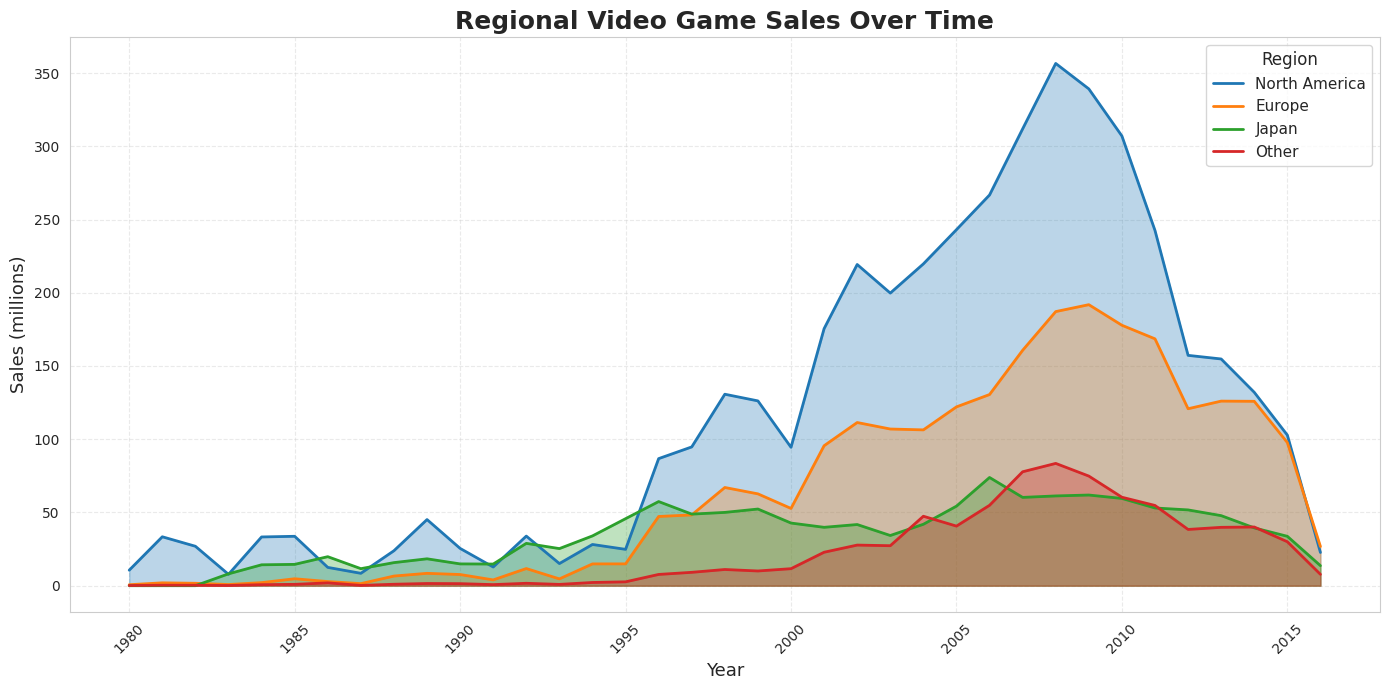

In [23]:
regional_sales_pd = regional_sales_pd.sort_values("Year")

plt.figure(figsize=(14, 7))

plt.plot(regional_sales_pd["Year"], regional_sales_pd["NA_Sales"], label="North America", color="#1f77b4", linewidth=2)
plt.fill_between(regional_sales_pd["Year"], regional_sales_pd["NA_Sales"], alpha=0.3, color="#1f77b4")

plt.plot(regional_sales_pd["Year"], regional_sales_pd["EU_Sales"], label="Europe", color="#ff7f0e", linewidth=2)
plt.fill_between(regional_sales_pd["Year"], regional_sales_pd["EU_Sales"], alpha=0.3, color="#ff7f0e")

plt.plot(regional_sales_pd["Year"], regional_sales_pd["JP_Sales"], label="Japan", color="#2ca02c", linewidth=2)
plt.fill_between(regional_sales_pd["Year"], regional_sales_pd["JP_Sales"], alpha=0.3, color="#2ca02c")

plt.plot(regional_sales_pd["Year"], regional_sales_pd["Other_Sales"], label="Other", color="#d62728", linewidth=2)
plt.fill_between(regional_sales_pd["Year"], regional_sales_pd["Other_Sales"], alpha=0.3, color="#d62728")

plt.title("Regional Video Game Sales Over Time", fontsize=18, fontweight="bold")
plt.xlabel("Year", fontsize=13)
plt.ylabel("Sales (millions)", fontsize=13)
plt.xticks(rotation=45)
plt.legend(title="Region", fontsize=11, title_fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

###  Years with most game releases and number of hits

In [24]:
hit_years = df.groupBy("Name", "Year") \
    .agg(sum("Global_Sales").alias("Total_Global_Sales")) \
    .withColumn("Is_Hit", when(col("Total_Global_Sales") > 1.0, 1).otherwise(0)) \
    .groupBy("Year") \
    .agg(
        count("*").alias("Num_Unique_Games"),
        sum("Is_Hit").alias("Num_Hits")
    ) \
    .orderBy(col("Num_Hits").desc())

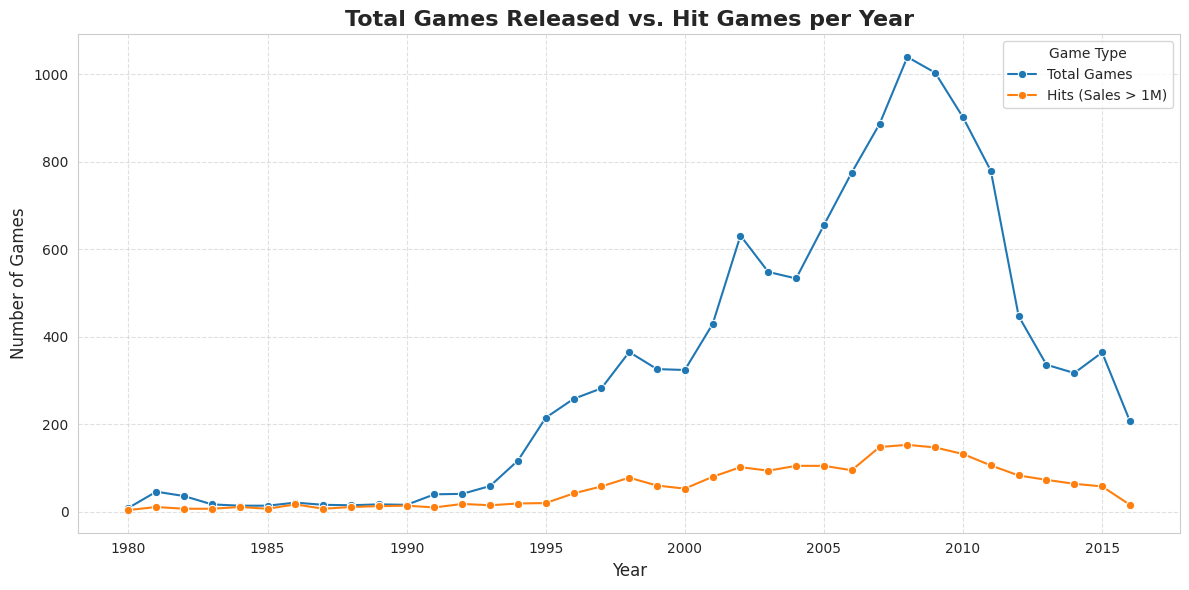

In [25]:
hit_years_pd = hit_years.toPandas().sort_values("Year")

plt.figure(figsize=(12, 6))
sns.lineplot(data=hit_years_pd, x="Year", y="Num_Unique_Games", label="Total Games", marker="o")
sns.lineplot(data=hit_years_pd, x="Year", y="Num_Hits", label="Hits (Sales > 1M)", marker="o")

plt.title("Total Games Released vs. Hit Games per Year", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Games", fontsize=12)
plt.legend(title="Game Type")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### Most popular genres by decade

In [26]:
df.withColumn("Decade", floor(col("Year") / 10) * 10) \
  .groupBy("Decade", "Genre").count() \
  .orderBy("Decade", col("count").desc()) \
  .show()

+------+------------+-----+
|Decade|       Genre|count|
+------+------------+-----+
|  1980|      Action|   66|
|  1980|    Platform|   33|
|  1980|     Shooter|   30|
|  1980|      Sports|   23|
|  1980|      Puzzle|   19|
|  1980|Role-Playing|    9|
|  1980|      Racing|    8|
|  1980|        Misc|    8|
|  1980|    Fighting|    4|
|  1980|  Simulation|    3|
|  1980|   Adventure|    2|
|  1990|      Sports|  304|
|  1990|    Fighting|  193|
|  1990|      Racing|  183|
|  1990|Role-Playing|  172|
|  1990|      Action|  163|
|  1990|     Shooter|  138|
|  1990|    Platform|  125|
|  1990|    Strategy|  123|
|  1990|        Misc|  116|
+------+------------+-----+
only showing top 20 rows



## Publisher Performance

### Publishers with most games

In [27]:
top_publishers = df.groupBy("Publisher") \
  .count() \
  .withColumnRenamed("count", "Num_Games") \
  .orderBy(col("Num_Games").desc())

top_publishers.show()

+--------------------+---------+
|           Publisher|Num_Games|
+--------------------+---------+
|     Electronic Arts|     1348|
|          Activision|      972|
|  Namco Bandai Games|      931|
|             Ubisoft|      920|
|Konami Digital En...|      825|
|                 THQ|      712|
|            Nintendo|      698|
|Sony Computer Ent...|      682|
|                Sega|      635|
|Take-Two Interactive|      413|
|              Capcom|      379|
|               Atari|      349|
|          Tecmo Koei|      338|
|         Square Enix|      232|
|Warner Bros. Inte...|      232|
|Disney Interactiv...|      217|
|   Eidos Interactive|      197|
|        Midway Games|      196|
|           505 Games|      192|
|Microsoft Game St...|      189|
+--------------------+---------+
only showing top 20 rows



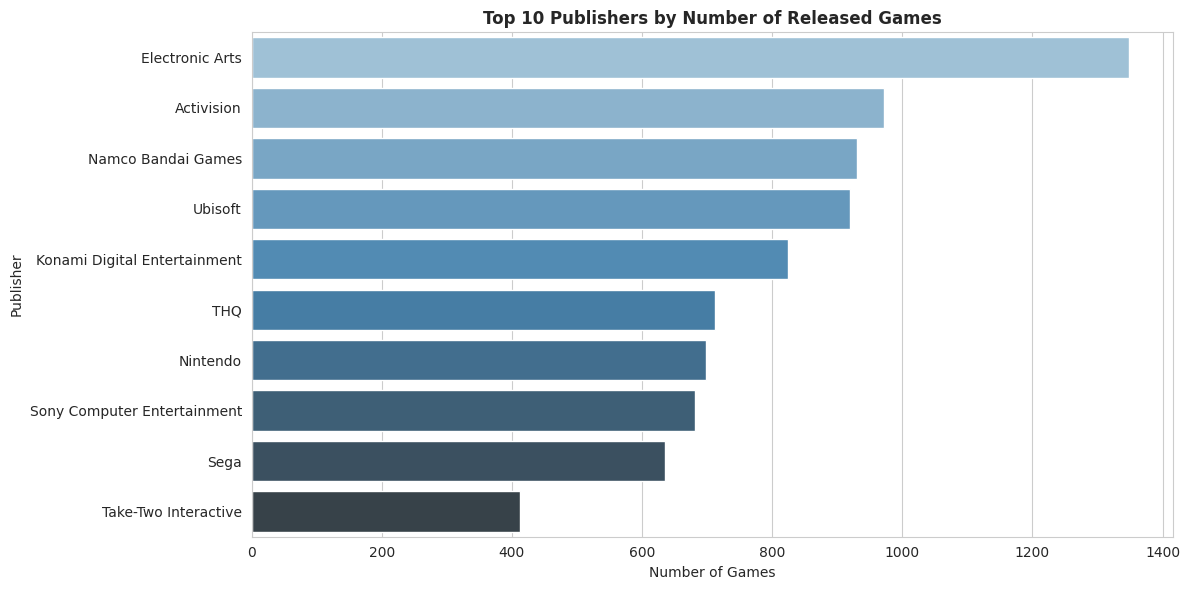

In [28]:
top_publishers_pd = top_publishers.limit(10).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_publishers_pd, x="Num_Games", y="Publisher", hue='Publisher', palette="Blues_d")
plt.title("Top 10 Publishers by Number of Released Games",  fontweight="bold")
plt.xlabel("Number of Games")
plt.ylabel("Publisher")
plt.tight_layout()
plt.show()

## Publishers with highest average global sales

In [29]:
df.groupBy("Publisher").avg("Global_Sales").orderBy(col("avg(Global_Sales)").desc()).show()

+--------------------+------------------+
|           Publisher| avg(Global_Sales)|
+--------------------+------------------+
|              Palcom|              4.17|
|             Red Orb|              2.62|
|            Nintendo|  2.55699140401146|
| Arena Entertainment|              2.36|
|         UEP Systems|              2.25|
|           RedOctane|              2.17|
|               Valve|              1.74|
|         Hello Games|               1.6|
|Sony Computer Ent...|1.5926666666666667|
|    Westwood Studios|              1.55|
|Microsoft Game St...|1.3004761904761903|
|              Imagic|             1.205|
|   Black Label Games|               1.2|
|  Bethesda Softworks|1.1569014084507043|
|               Maxis|              1.13|
|    Enix Corporation|1.1246666666666663|
|          SquareSoft|1.1086538461538464|
|      Valve Software|1.0766666666666669|
|           LucasArts|0.9704444444444447|
|Take-Two Interactive|0.9674092009685228|
+--------------------+------------

## Market Patterns & Correlations

In [30]:
num_cols

['Rank',
 'Year',
 'NA_Sales',
 'EU_Sales',
 'JP_Sales',
 'Other_Sales',
 'Global_Sales',
 'NA_Sales_log',
 'EU_Sales_log',
 'JP_Sales_log',
 'Other_Sales_log',
 'Global_Sales_log',
 'Is_Japan_Hit']

In [31]:
pandas_df[num_cols[1:7]].corr(numeric_only=True)

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Year,1.000000,-0.091601,0.006077,-0.169151,0.041011,-0.074801
NA_Sales,-0.091601,1.000000,0.767902,0.450400,0.634742,0.941110
EU_Sales,0.006077,0.767902,1.000000,0.435749,0.726268,0.902876
JP_Sales,-0.169151,0.450400,0.435749,1.000000,0.290211,0.612147
Other_Sales,0.041011,0.634742,0.726268,0.290211,1.000000,0.748242
Global_Sales,-0.074801,0.941110,0.902876,0.612147,0.748242,1.000000


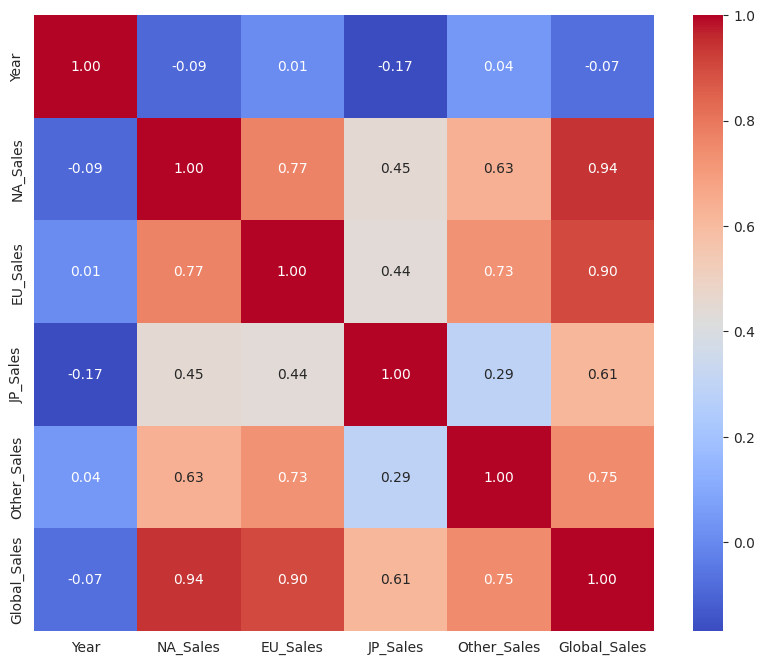

In [32]:
plt.figure(figsize=(10,8))
sns.heatmap(data=pandas_df[num_cols[1:7]].corr(numeric_only=True), annot=True, fmt='.2f',cmap='coolwarm');

#### Strong correlations with Global_Sales:

* NA_Sales and EU_Sales have the strongest impact on global sales-that is, most sales are in North America and Europe.
* JP_Sales and Other_Sales also have an impact, but are less significant for the global result.

#### Mutual correlation of regions:

* NA\_Sales and EU\_Sales and EU\_Sales and Other\_Sales - the high correlation suggests that games that sell well in one Western region are often successful in others as well.
* JP_Sales has a weaker correlation with other regions:

  * NA, EU, Other.
  * This means that the Japanese market has specific preferences and is often different from the rest of the world.

#### Release Year (Year):

* Correlations with year are very weak.
* We can conclude that the year of a game's release does not have a large impact on sales volume.

### Conclusions:

1. global sales depend most strongly on the US and European markets.
2. the Japanese market operates more independently, it is worth analyzing separately.
3. The time variable (Year) has a marginal effect.

### Genres performing better in Japan vs. North America

In [33]:
df.groupBy("Genre").avg("JP_Sales", "NA_Sales").orderBy(col("avg(JP_Sales)").desc()).show()

+------------+--------------------+-------------------+
|       Genre|       avg(JP_Sales)|      avg(NA_Sales)|
+------------+--------------------+-------------------+
|Role-Playing|  0.2382744565217388|0.22186141304347815|
|    Platform| 0.14914383561643843| 0.5091210045662092|
|    Fighting| 0.10362663495838295|0.26329369797859686|
|      Puzzle| 0.09874564459930313| 0.2135888501742161|
|  Simulation| 0.07475294117647059|0.21407058823529426|
|    Strategy| 0.07278518518518519|0.10103703703703708|
|        Misc|  0.0633470588235294|0.23474117647058815|
|      Sports|0.057957957957958016|0.29197769197769163|
|      Action| 0.04828058429701776| 0.2655173463177102|
|      Racing| 0.04584615384615383|0.28985425101214507|
|   Adventure|0.040776470588235345|0.07994509803921572|
|     Shooter|0.029452582883577504|0.44773323053199604|
+------------+--------------------+-------------------+



### Do multi-platform games perform better globally?

In [34]:
multi_platform_sales = df.groupBy("Name") \
    .agg(
        countDistinct("Platform").alias("Platform_Count"),
        sum("Global_Sales").alias("Total_Sales")
    ) \
    .orderBy(col("Platform_Count").desc())

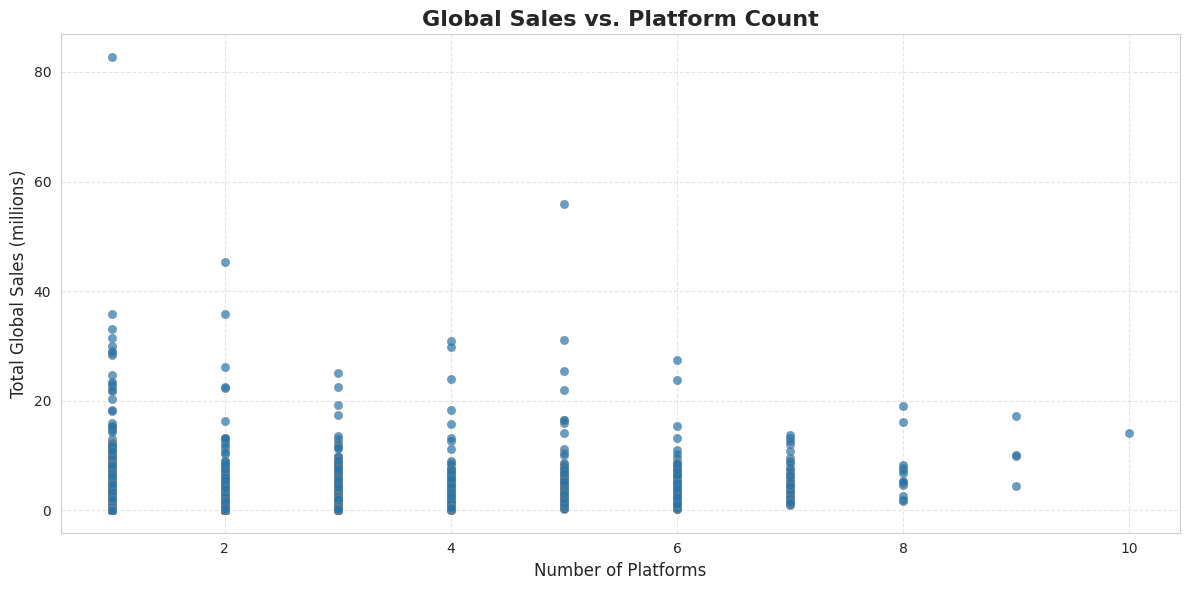

In [35]:
multi_platform_pd = multi_platform_sales.toPandas()

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=multi_platform_pd,
    x="Platform_Count",
    y="Total_Sales",
    alpha=0.7,
    edgecolor="gray"
)

plt.title("Global Sales vs. Platform Count", fontsize=16, fontweight='bold')
plt.xlabel("Number of Platforms", fontsize=12)
plt.ylabel("Total Global Sales (millions)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Being on many platforms can help broaden reach, but the biggest hits are often driven by title strength, franchise power, or platform bundling not just availability.

### 🔍 Key Insights from the Analysis

### 1. **Main Trends Observed**

#### 📈 1980s – Rapid Sales Growth

* A significant spike in sales occurred in the mid-1980s, especially visible in global and North American data.
* Global sales peaked in 1989, with North America contributing a large portion.
* This reflects a booming video game industry during that period.

#### 📉 1990s – Decline and Stabilization

* After the late-80s peak, sales declined sharply.
* The 1990s were marked by instability — some temporary spikes, but an overall downward trend.
* Japan and Europe remained more stable but with lower sales levels.

#### 🔄 Post-2000 – Stabilization at Lower Levels

* Since the early 2000s, annual average sales across all regions have remained lower than in the ‘80s and ‘90s.
* Global sales ranged within moderate levels, with regional contributions typically lower.

#### 📊 Recent Years – Modest Rebound

* A slight increase in sales has been observed since around 2012, especially globally.

### 2. **Market Segmentation Findings**

* The video game market can be segmented by region, platform, genre, and publisher.

#### 🕹 Platforms

* Older consoles like PS2 and Wii dominated in total sales, reflecting their longevity and large user bases.

#### 🎮 Genres

* Action, sports, and shooter games were top-selling, especially in Western markets.
* RPGs were relatively stronger in Japan.

#### 🏢 Publishers

* Nintendo, Electronic Arts, and Activision led the charts, showing how powerful IPs and strong brand recognition impact success.

### 3. **Correlations and Relationships**

#### 📊 What influences global sales the most?

* North American and European markets are the biggest drivers of global sales.
* Japan and other regions have some influence, but less overall weight in global totals.

#### 🌍 Inter-regional patterns

* Strong overlaps exist between Western regions — games that sell well in North America often also perform well in Europe and other regions.
* Japan tends to behave more independently, with different preferences and sales behavior.

#### 📆 Release Year

* There is little to no consistent relationship between a game’s release year and how much it sells.
* Time is not a strong predictor of performance.

**Conclusion:**

* Global success is mainly driven by North America and Europe.
* Japan is unique and should be studied separately.
* Release timing (in terms of year) has a marginal impact on sales outcomes.

### 4. **Outliers Identified**

* A few games achieved extraordinarily high sales, far above the norm.
* These outliers skew summary statistics and highlight the uneven distribution of success in the market.


### 5. Analysis Limitations

#### 📉 Data Limitations

* Dataset ends in 2020 and excludes digital sales, which have been dominant since \~2015.
* Only release year is available (no exact dates), limiting detailed trend or event-based analysis.
* Sales are in units only — no info on prices, revenues, or discounts.

#### 📉 Methodological Limitations

* Factors like marketing, exclusivity, and reviews were not considered.
* Annual aggregation hides short-term patterns or market shifts.

#### 📉 Interpretational Limitations

* High unit sales don’t always mean financial success — no cost data included.
* The market has shifted significantly since 2020 (F2P, subscriptions, cloud gaming), so findings may not fully apply to today’s landscape.